In [3]:
import numpy as np
import scipy as sp
import scipy.stats as st
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mp
mp.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
# force inline plots
# %matplotlib inline
plt.style.use('seaborn-deep')
import torch.nn as nn
import copy
import pandas as pd
import sys
import os
import utils
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
# seed = 128
# rnd  = np.random.RandomState(seed)
#matplotlib configurations
def use_svg_display(): 
    """Use the svg format to display a plot in Jupyter for sharper images!"""
    backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):  
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
    
def DR(s, theta):
    return sp.special.gammainc(s, theta)

def DL(s, theta):
    return 1 - sp.special.gammainc(s+1, theta)
import random

Load a trained model

In [2]:
model = torch.load( 'TWO_PARAMETERS_TRAINED _MODEL.pth')

print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
model.0.weight 	 torch.Size([128, 4])
model.0.bias 	 torch.Size([128])
model.1.weight 	 torch.Size([128])
model.1.bias 	 torch.Size([128])
model.1.running_mean 	 torch.Size([128])
model.1.running_var 	 torch.Size([128])
model.1.num_batches_tracked 	 torch.Size([])
model.4.weight 	 torch.Size([128, 128])
model.4.bias 	 torch.Size([128])
model.5.weight 	 torch.Size([128])
model.5.bias 	 torch.Size([128])
model.5.running_mean 	 torch.Size([128])
model.5.running_var 	 torch.Size([128])
model.5.num_batches_tracked 	 torch.Size([])
model.8.weight 	 torch.Size([128, 128])
model.8.bias 	 torch.Size([128])
model.9.weight 	 torch.Size([128])
model.9.bias 	 torch.Size([128])
model.9.running_mean 	 torch.Size([128])
model.9.running_var 	 torch.Size([128])
model.9.num_batches_tracked 	 torch.Size([])
model.12.weight 	 torch.Size([128, 128])
model.12.bias 	 torch.Size([128])
model.13.weight 	 torch.Size([128])
model.13.bias 	 torch.Size([128])
model.13.running_mean 	 torch.Size([

Correct shaping for our data

In [19]:
N, M = 2, 3
points = [(theta, nu) for theta, nu in 
        zip(np.random.randint(low=0,high=4,size=6), np.random.randint(low=0,high=4,size=6))]
theta, nu = points[0]

X = np.array([theta, nu, N, M]) 
X=X.reshape(1,-1)

X =torch.Tensor(X)
X.shape


torch.Size([1, 4])

# Minibatch
The concept of minibatches is fundamental to training an ML model. Let's generate data and access them in batches

In [6]:
torch.normal(0, 1, (3, 4))

tensor([[-1.2737e+00,  1.7328e-01,  1.1156e-01,  2.3508e-01],
        [-1.0235e+00, -9.6387e-01,  5.9923e-01, -9.1092e-04],
        [-3.0900e+00, -5.8915e-01, -9.3988e-01,  2.0903e-01]])

In [9]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)# noise term
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features[:5], labels[:5]

(tensor([[-0.0562, -0.4451],
         [ 0.8839, -0.4414],
         [-0.4544, -0.2906],
         [ 0.3892,  0.7024],
         [ 0.0430, -0.3618]]),
 tensor([[5.6019],
         [7.4903],
         [4.2720],
         [2.6031],
         [5.5131]]))

{features, labels, batch_size} $\rightarrow$ data_iter $\rightarrow$ features[batch_index], labels[batch_index]

In [10]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        

In [13]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.1840,  0.4181],
        [-0.5254, -2.3070],
        [ 1.6039, -1.7719],
        [ 0.7554, -1.4603],
        [ 2.0491,  2.2939],
        [-0.2689,  0.0716],
        [-2.0974, -0.0233],
        [-0.8122,  1.3602],
        [-0.2452,  0.6785],
        [-0.9300, -0.9762]]) 
 tensor([[ 0.4069],
        [10.9828],
        [13.4321],
        [10.6778],
        [ 0.5063],
        [ 3.4177],
        [ 0.0798],
        [-2.0425],
        [ 1.4001],
        [ 5.6748]])


# Autograd

Suppose we have a multivariate function $f(\mathbf{x})$, wheren the input to the function is an $n$-dimensional vector $\mathbf{x}=[x_1, x_2, ..., x_n]^T$, and the output is a scalar. Then
The gradiant of function $f(\mathbf{x})$ with respect to $\mathbf{x}$ is 
$$ \nabla_{\mathbf{x}} f(\mathbf{x})=\left[\frac{\partial f(\mathbf{x})}{\partial x_{1}}, \frac{\partial f(\mathbf{x})}{\partial x_{2}}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_{n}}\right]^{\top} $$

Of course, the gradiant (of a scalar function) will be a vector, and will have the same shape as $\mathbf{x}$.

In [28]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

Suppose that $y=2 \mathbf{x}^{\top} \mathbf{x}$, and say we want to differentiate it with respect to the column vector $x$. Before we can calculate $\nabla_\mathbf{x} y(\mathbf{x})$ we need a place to store it. 

It is important that we don't allocate new memory every time we take a derivative with respect to a parameter, since during training we update parameters millions of times so we could run out of memory quickly. Therefore we first have to say that we want to store the gradiants of this vector

In [33]:
x.requires_grad_(True)
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [34]:
x.grad?

Type:        property
String form: <property object at 0x7f85acf5ff50>
Docstring:  
This attribute is ``None`` by default and becomes a Tensor the first time a call to
:func:`backward` computes gradients for ``self``.
The attribute will then contain the gradients computed and future calls to
:func:`backward` will accumulate (add) gradients into it.


In [35]:
x.grad#default is none as expected

In [36]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

Next, we can automatically calculate the gradient of y with respect to each component of x,$\nabla_\mathbf{x} y(\mathbf{x})$, by calling the function for backpropagation and printing the gradient.

In [37]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [38]:
x

tensor([0., 1., 2., 3.], requires_grad=True)

Since $y=2 \mathbf{x}^{\top} \mathbf{x}$, $\nabla_\mathbf{x} y(\mathbf{x})=4 \mathbf{x}$. Let's verify that pytorch calculated the gradient correctly

In [39]:
x.grad == 4 * x

tensor([True, True, True, True])

In [40]:
# PyTorch accumulates the gradient in default, we need to clear the previous
# values
x.grad.zero_()
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [41]:
#calculate the gradient of another function

In [42]:
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

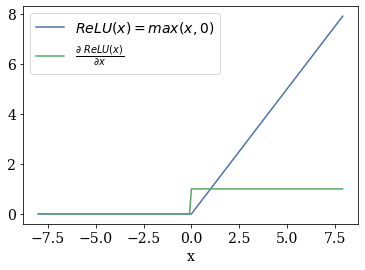

In [27]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
plt.plot(x.detach(), y.detach(), label=r'$ReLU(x) = max(x,0)$')
plt.xlabel('x')
y.backward(torch.ones_like(x), retain_graph=True)
plt.plot(x.detach(), x.grad, label=r'$\frac{\partial \ ReLU(x)}{\partial x}$')
plt.legend()

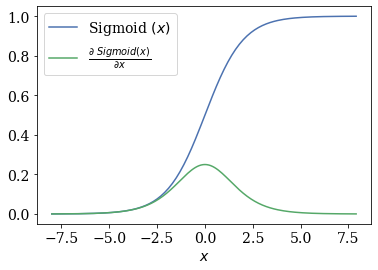

In [29]:
y = torch.sigmoid(x)
plt.plot(x.detach(), y.detach(), label=r'Sigmoid $(x)$')
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad, label=r'$\frac{\partial \ Sigmoid(x)}{\partial x}$')
plt.xlabel(r'$x$'); plt.legend()

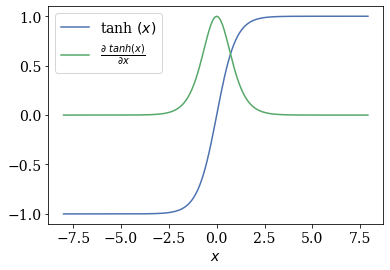

In [30]:
y = torch.tanh(x)
plt.plot(x.detach(), y.detach(), label=r'tanh $(x)$')
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad, label=r'$\frac{\partial \ tanh(x)}{\partial x}$')
plt.xlabel(r'$x$'); plt.legend()